In [32]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!pip install japanize_matplotlib
!pip install optuna
import japanize_matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import LabelEncoder
import datetime as dt
import optuna.integration.lightgbm as lgbm
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import itertools

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

In [34]:
STUDY_EDA = False
DEBUG = False

input_path = '/content/drive/MyDrive/input/signate_car_distance/'
output_path = '/content/drive/MyDrive/output/signate_car_distance/'
interm_path = '/content/drive/MyDrive/intermediate/signate_car_distance/'
now = dt.datetime.today()
month = str(now.month)
day = str(now.day)
comment = 'car_distance_prediction'

save_nm = f'submission_{comment}_{month}_{day}.csv'
print(save_nm)

submission_car_distance_prediction_11_20.csv


In [35]:
train_df = pd.read_csv(input_path + 'train.csv')
test_df = pd.read_csv(input_path + 'test.csv')

In [36]:
sample_submission_df = pd.read_csv(input_path + 'sample_submit.csv', header = None)

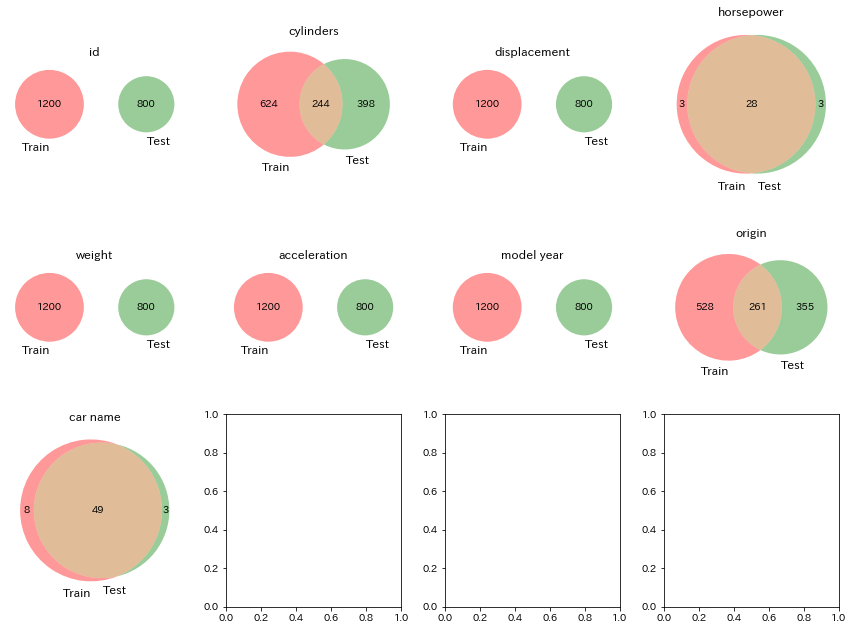

In [37]:
from matplotlib_venn import venn2
columns = test_df.columns
n_figs = len(columns)
n_cols = 4
n_rows = n_figs // n_cols + 1

fig, axes = plt.subplots(figsize=(n_cols * 3, n_rows * 3), ncols=n_cols, nrows=n_rows)

for c, ax in zip(columns, axes.ravel()):
    venn2(
        subsets=(set(train_df[c].unique()), set(test_df[c].unique())),
        set_labels=('Train', 'Test'),
        ax=ax
    )
    ax.set_title(c)

fig.tight_layout()

In [38]:
train_df['train_test'] = 'train'
test_df['train_test'] = 'test'
train_test = pd.concat([train_df, test_df], axis = 0).reset_index(drop = True)

In [39]:
print(train_test.shape)
train_test.head(3)

(2000, 11)


,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg,train_test
0,0,8.002,308.763915,140,2682.667484,13.361159,79.000820,0.998,mercury cougar brougham,17.786401,train
1,1,8.002,421.557379,220,2160.223156,9.672329,70.623025,0.998,datsun 710,17.194679,train
2,2,4.002,95.382697,70,1861.752560,17.544130,81.416513,0.998,peugeot 504,36.180575,train


In [40]:
print(train_test.isnull().sum())

id                0
cylinders         0
displacement      0
horsepower        0
weight            0
acceleration      0
model year        0
origin            0
car name          0
mpg             800
train_test        0
dtype: int64


In [41]:
print(train_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            2000 non-null   int64  
 1   cylinders     2000 non-null   float64
 2   displacement  2000 non-null   float64
 3   horsepower    2000 non-null   object 
 4   weight        2000 non-null   float64
 5   acceleration  2000 non-null   float64
 6   model year    2000 non-null   float64
 7   origin        2000 non-null   float64
 8   car name      2000 non-null   object 
 9   mpg           1200 non-null   float64
 10  train_test    2000 non-null   object 
dtypes: float64(7), int64(1), object(3)
memory usage: 172.0+ KB
None


In [42]:
for col_nm in train_test.columns:
    print(col_nm)
    print(train_test[col_nm].nunique())
    print(train_test[col_nm].unique())

    print('*'*80)
    print('*'*80)
    print('*'*80)

id
2000
[   0    1    2 ... 1997 1998 1999]
********************************************************************************
********************************************************************************
********************************************************************************
cylinders
1266
[8.00199994 8.00199992 4.00199983 ... 6.00199976 4.00199897 4.00199997]
********************************************************************************
********************************************************************************
********************************************************************************
displacement
2000
[308.7639152 421.5573791  95.3826971 ... 225.1894008 307.6514483
 147.0325536]
********************************************************************************
********************************************************************************
********************************************************************************
horsepower
34
['140' '220' '70' '85' '150' 

In [43]:
train_test['model year'] = train_test['model year'].astype(float)
train_test['origin'] = train_test['origin'].astype(float)

In [44]:
len(train_test[train_test['horsepower'] == '?'])
tmp_train_test = train_test[train_test['horsepower'] != '?']
horsepower_mean = tmp_train_test['horsepower'].astype(float).mean()
print(horsepower_mean)

106.88107549120993


In [45]:
train_test['horsepower'] = train_test['horsepower'].apply(lambda x:str(int(np.round(horsepower_mean))) if x == '?' else x)
train_test['horsepower'].unique()

array(['140', '220', '70', '85', '150', '97', '112', '60', '100', '120',
       '107', '139', '90', '108', '122', '148', '71', '72', '69', '110',
       '67', '130', '95', '145', '132', '75', '193', '54', '78', '61',
       '64', '165', '58', '135'], dtype=object)

In [46]:
train_test['horsepower'] = train_test['horsepower'].astype(int)

In [47]:
train_test.describe()

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,1200.000000
mean,999.500000,5.262999,186.208705,106.885000,2621.599862,15.182220,77.465094,1.334001,27.475247
std,577.494589,1.655672,105.845911,35.830583,706.485418,2.071908,3.784511,0.700249,7.521617
min,0.000000,4.001979,82.270213,54.000000,1714.444811,9.565413,70.314473,0.998000,16.935547
25%,499.750000,4.002000,97.742072,75.000000,2101.176298,13.406932,75.255464,0.998000,22.700008
50%,999.500000,4.002000,137.092441,97.000000,2304.023111,15.152209,77.740396,0.998000,27.689721
75%,1499.250000,6.002000,306.361754,139.000000,3171.212409,15.540470,81.436179,0.998002,35.855009
max,1999.000000,8.002000,425.284954,220.000000,4632.432969,21.498304,82.327672,2.998008,45.076959


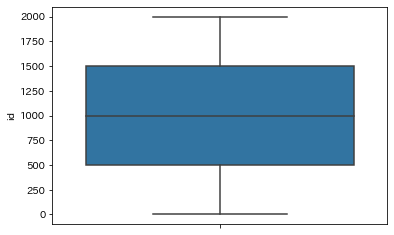

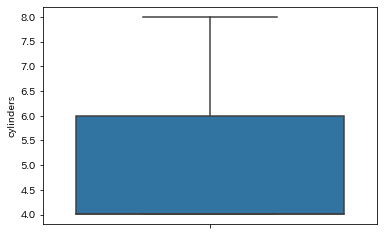

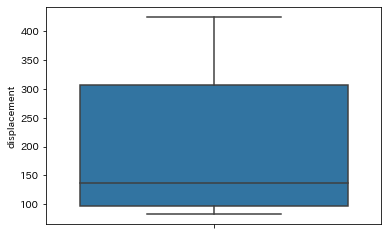

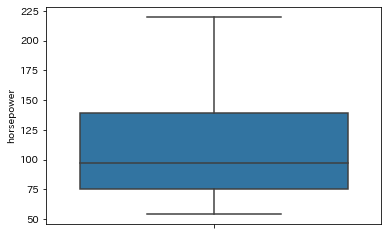

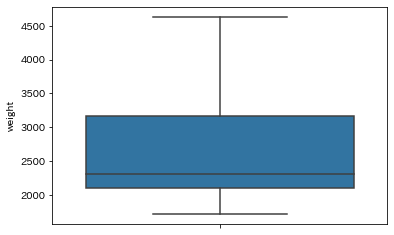

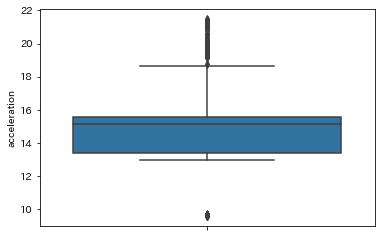

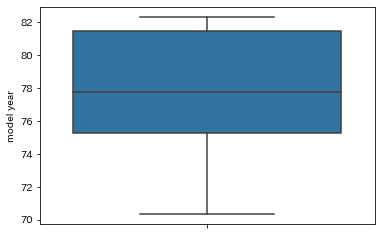

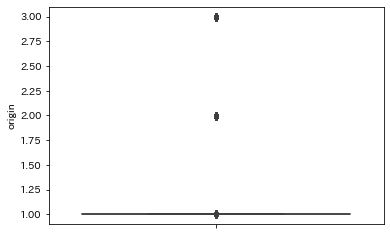

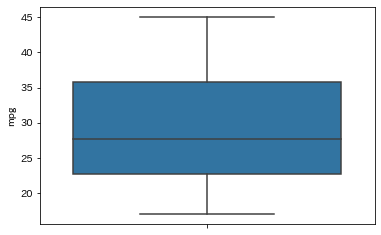

In [48]:
for col_nm in train_test.columns:

    if train_test[col_nm].dtype != 'object':

        sns.boxplot(y = col_nm, data = train_test)
        plt.show()

        print()
        print()

In [49]:
print(len(train_test[train_test['acceleration'] <= 10]))
train_test[train_test['acceleration'] <= 10].head()

49


,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg,train_test
1,1,8.002000,421.557379,220,2160.223156,9.672329,70.623025,0.998,datsun 710,17.194679,train
14,14,8.001996,421.150215,100,2164.689146,9.653637,70.610062,0.998,datsun 710,17.704698,train
150,150,8.002000,424.937861,220,2161.397944,9.651214,70.573467,0.998,datsun 710,17.715098,train
177,177,8.002000,420.262443,220,2152.270727,9.666607,70.793417,0.998,datsun 710,17.638756,train
195,195,8.002000,421.837631,220,2143.927818,9.625297,70.593961,0.998,datsun 710,17.134397,train


In [50]:
print(len(train_test[train_test['origin'] >= 1.5]))
train_test[train_test['origin'] >= 1.5].head()

405


,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg,train_test
3,3,4.002000,133.990715,85,2315.158110,15.466768,76.038414,2.998000,datsun 210 mpg,35.718788,train
10,10,4.001999,140.155665,100,3789.576787,13.620148,82.012501,1.998000,buick century limited,35.260662,train
28,28,6.002000,145.831795,108,2171.512404,13.348197,76.984736,2.998001,audi 5000s (diesel),23.284204,train
31,31,6.002000,134.500078,108,2172.937564,13.344677,77.085419,2.998001,audi 5000s (diesel),17.883929,train
39,39,4.001995,136.603816,100,3779.123974,13.607401,82.237161,1.998000,buick century limited,36.325496,train


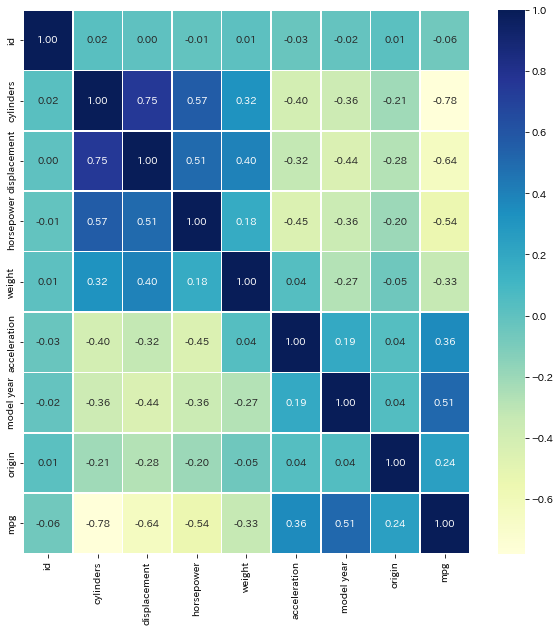

In [51]:
plt.figure(figsize = (10, 10))
sns.heatmap(train_test.corr(), fmt="1.2f", annot=True, lw=0.7, cmap='YlGnBu')

In [52]:
train_test['company_name'] = train_test['car name'].apply(lambda x:x.split(' ')[0])
train_test.head(3)

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg,train_test,company_name
0,0,8.002,308.763915,140,2682.667484,13.361159,79.000820,0.998,mercury cougar brougham,17.786401,train,mercury
1,1,8.002,421.557379,220,2160.223156,9.672329,70.623025,0.998,datsun 710,17.194679,train,datsun
2,2,4.002,95.382697,70,1861.752560,17.544130,81.416513,0.998,peugeot 504,36.180575,train,peugeot


In [53]:
train_test['company_name'].unique()

array(['mercury', 'datsun', 'peugeot', 'triumph', 'pontiac', 'saab',
       'toyouta', 'ford', 'buick', 'chevrolet', 'dodge', 'honda', 'vw',
       'audi', 'plymouth', 'opel', 'amc', 'capri', 'volkswagen', 'toyota',
       'hi', 'fiat', 'oldsmobile', 'renault'], dtype=object)

In [54]:
def company_standlize(x):

    if x == 'toyouta':
        return 'toyota'
    
    elif x == 'volkswagen':
        return 'vw'

    elif x == 'capri':
        return 'ford'

    elif x == 'mercury':
        return 'ford'

    elif x == 'datsun':
        return 'nissan'

    elif x == 'pontiac':
        return 'gm'
    
    elif x == 'buick':
        return 'gm'

    elif x == 'plymouth':
        return 'chrysler'


    else:
        return x

In [55]:
train_test['company_name'] = train_test['company_name'].apply(company_standlize)
train_test['company_name'].unique()

array(['ford', 'nissan', 'peugeot', 'triumph', 'gm', 'saab', 'toyota',
       'chevrolet', 'dodge', 'honda', 'vw', 'audi', 'chrysler', 'opel',
       'amc', 'hi', 'fiat', 'oldsmobile', 'renault'], dtype=object)

In [56]:
train_test.columns.tolist()

['id',
 'cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'model year',
 'origin',
 'car name',
 'mpg',
 'train_test',
 'company_name']

In [57]:
train_test.dtypes

id                int64
cylinders       float64
displacement    float64
horsepower        int64
weight          float64
acceleration    float64
model year      float64
origin          float64
car name         object
mpg             float64
train_test       object
company_name     object
dtype: object

In [58]:
def grouping_describe(df, key_describe_cols, stat_describe_cols, agg_describe_kinds):
      
    """
    統計値を取得する

    Args:
        df(DataFrame):前処理するデータ
        agg_describe_kinds(リスト):統計リスト
        
    Returns:
        df(DataFrame)
        
    """  
        
    for key_col, agg_kind, stat_col in itertools.product(key_describe_cols, agg_describe_kinds, stat_describe_cols):
        
        df['group_by_' + key_col + 'stat_' + stat_col + '_' + agg_kind] = df.groupby([key_col])[stat_col].transform(agg_kind)

        
        if agg_kind in ['max', 'mean', 'min']:
            
            df['group_by_' + key_col + 'diff_' + stat_col + '_' + agg_kind] = df['group_by_' + key_col + 'stat_' + stat_col + '_' + agg_kind] - df[stat_col]

        
    return df

In [59]:
print('***********************************************************************************')
print('preprocessing...grouping_describe')
# breath_idごとに統計値を算出する
# df.groupby(['breath_id'])[stat_col].transform(agg_kind)

key_describe_cols = [
    'car name',
    'company_name'
]

stat_describe_cols = [
    'cylinders',
    'displacement',
    'horsepower',
    'weight',
    'acceleration',
    'model year',
    'origin'
]

agg_describe_kinds = [
    'count', 
    'mean', 
    'min', 
    'max',
    'nunique',
    'std' 
]

train_test = grouping_describe(train_test, key_describe_cols, stat_describe_cols, agg_describe_kinds)

print('finished')
print('***********************************************************************************')

***********************************************************************************
preprocessing...grouping_describe
finished
***********************************************************************************


In [60]:
label_cols = [
    'car name',
    'company_name'
]

for label_col in label_cols:
    le = LabelEncoder()
    train_test[label_col] = train_test[label_col].fillna(train_test[label_col].mode()[0])
    train_test[label_col] = le.fit_transform(train_test[label_col])

In [61]:
target = 'mpg'

preprocessed_train_df = train_test[train_test['train_test'] == 'train'].drop(columns = ['train_test', 'id'])
preprocessed_test_df = train_test[train_test['train_test'] == 'test'].drop(columns = ['train_test', 'id', target])

x = preprocessed_train_df.drop(columns = target)
y = preprocessed_train_df[target]

In [62]:
# foldデータ作成
fold = KFold(n_splits=5, shuffle=True, random_state=42)
# fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = list(fold.split(x, y))

In [63]:
def fit_lgbm(x, y, cv, params: dict=None, verbose=100):
        
    oofs_lgbm = []
    models_lgbm = []
    scores_lgbm = []
    
    for i, (idx_train, idx_valid) in enumerate(cv): 
        
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = x[idx_train], y[idx_train]
        x_valid, y_valid = x[idx_valid], y[idx_valid]
        
        oof_pred = np.zeros(len(y_valid), dtype=np.float32)
        
        trains = lgbm.Dataset(x_train, y_train)
        valids = lgbm.Dataset(x_valid, y_valid)

        model = lgbm.train(
            params, 
            trains,
            valid_sets = valids,
            num_boost_round = 50000,
            verbose_eval = False,
            early_stopping_rounds = 100
        )

        
        oof_pred = model.predict(x_valid)
        score = np.sqrt(mse(oof_pred, y_valid))

        print('*'*50)
        print('*'*50)
        print('*'*50)
        
        print(f'fold{i+1}finished')
        print('rmse:', score)
        
        print('*'*50)
        print('*'*50)
        print('*'*50)
        
        oofs_lgbm.append(oof_pred)
        models_lgbm.append(model)
        scores_lgbm.append(score)
        
    return oofs_lgbm, models_lgbm, scores_lgbm

params = {
    'objective':'regression',
    'metric':'rmse'
}

oofs_lgbm, models_lgbm, scores_lgbm = fit_lgbm(
    x.values, 
    y,
    cv,
    params
)

[I 2021-11-20 03:16:56,644] A new study created in memory with name: no-name-35b5fe1d-2a17-4a4e-b79f-0aef0544191a
min_data_in_leaf, val_score: 2.637345: 100%|##########| 5/5 [00:10<00:00,  2.18s/it]
[I 2021-11-20 03:18:11,374] A new study created in memory with name: no-name-662e0784-b7ee-406b-bbd8-11cddc5552ed


**************************************************
**************************************************
**************************************************
fold1finished
rmse: 2.637344971287325
**************************************************
**************************************************
**************************************************


min_data_in_leaf, val_score: 2.487062: 100%|##########| 5/5 [00:05<00:00,  1.10s/it]
[I 2021-11-20 03:19:37,376] A new study created in memory with name: no-name-6b6a245f-07ba-4f63-91bc-c025a5931bba


**************************************************
**************************************************
**************************************************
fold2finished
rmse: 2.4870621387117304
**************************************************
**************************************************
**************************************************


min_data_in_leaf, val_score: 2.373307: 100%|##########| 5/5 [00:04<00:00,  1.05it/s]
[I 2021-11-20 03:20:33,888] A new study created in memory with name: no-name-e081033f-0951-4864-a737-b83ae97fc432


**************************************************
**************************************************
**************************************************
fold3finished
rmse: 2.373307259624349
**************************************************
**************************************************
**************************************************


min_data_in_leaf, val_score: 3.127537: 100%|##########| 5/5 [00:06<00:00,  1.22s/it]
[I 2021-11-20 03:22:00,661] A new study created in memory with name: no-name-918cb957-11bb-4196-b3c4-7e473700b60a


**************************************************
**************************************************
**************************************************
fold4finished
rmse: 3.1275365721738058
**************************************************
**************************************************
**************************************************


min_data_in_leaf, val_score: 2.987754: 100%|##########| 5/5 [00:02<00:00,  1.86it/s]

**************************************************
**************************************************
**************************************************
fold5finished
rmse: 2.98775360755262
**************************************************
**************************************************
**************************************************


In [64]:
print(np.mean(scores_lgbm))

2.722600909869966


In [65]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

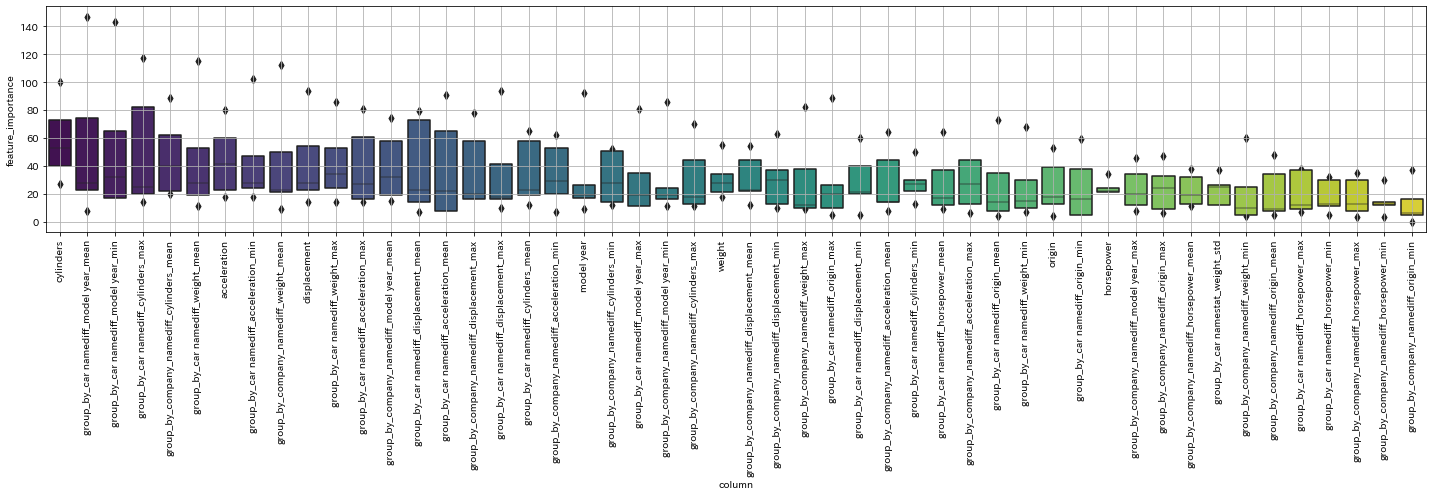

In [66]:
fig, ax = visualize_importance(models_lgbm, x)

In [67]:
y_pred_lgbm = np.array([model.predict(preprocessed_test_df.values) for model in models_lgbm])
y_pred_lgbm = np.mean(y_pred_lgbm, axis=0)

In [68]:
print(np.array([model.params for model in models_lgbm]))

[{'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 0.001623719692616159, 'lambda_l2': 0.00012295909870896774, 'num_leaves': 32, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
 {'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 0.0066084632509569525, 'lambda_l2': 0.016670356480999366, 'num_leaves': 24, 'feature_fraction': 0.9520000000000001, 'bagging_fraction': 0.7716908014501104, 'bagging_freq': 3, 'min_child_samples': 20}
 {'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 0.016831089849582613, 'lambda_l2': 2.775030122768352e-06, 'num_leaves': 151, 'feature_fraction': 0.5, 'bagging_fraction': 0.7161681399236515, 'bagging_freq': 5, 'min_child_samples': 20}
 {'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 0.00014635021444857295, 'lambda_l2': 3.599346879555207, 'num_leaves': 31, 'feature_frac

In [69]:
y_pred_lgbm

array([29.02517012, 27.28028886, 28.46005069, 22.37655721, 30.80486699,
       27.16225328, 36.13260538, 23.84432405, 23.42195871, 22.84835988,
       28.1499706 , 19.75385845, 29.93638218, 29.46072002, 17.85913534,
       17.73272894, 23.29504696, 33.99405236, 17.42423253, 36.20540435,
       17.60539296, 26.67325531, 23.40624788, 36.17374572, 28.4747712 ,
       22.81901647, 17.77209119, 18.02259847, 35.4411973 , 36.24184262,
       27.68069332, 29.14323653, 23.34211827, 22.91252762, 17.6119521 ,
       35.56973834, 35.32283279, 20.9280456 , 30.93819066, 41.84303537,
       27.47714315, 32.19437795, 22.89637207, 19.45665093, 28.03430993,
       36.214602  , 34.76614719, 27.28030089, 36.37887362, 29.72048834,
       22.93868045, 18.16214457, 23.12622537, 36.28243974, 17.88899957,
       36.43286541, 23.66200333, 35.81326541, 17.59615187, 32.27249883,
       23.1855578 , 26.29498096, 23.00952072, 17.78371651, 36.32514407,
       31.11765997, 23.39087473, 35.09874004, 39.71848979, 22.87

In [70]:
print(sample_submission_df.shape)
sample_submission_df.head()

(800, 2)


,0,1
0,1200,0
1,1201,0
2,1202,0
3,1203,0
4,1204,0


In [71]:
len(y_pred_lgbm)

800

In [72]:
sample_submission_df[1] = y_pred_lgbm
sample_submission_df.head()

,0,1
0,1200,29.025170
1,1201,27.280289
2,1202,28.460051
3,1203,22.376557
4,1204,30.804867


In [73]:
sample_submission_df.to_csv(output_path + save_nm, index = False)